In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (842663, 112)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829277, 113)



# Triage Accuracy

(How many patients did they get right and do they do it in the right order, for example: still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last.) Needs a confusion matrix.


## Did they get the correct tag applied?

In [4]:

# Investigate the columns of severity
# print([cn for cn in one_hot_encode_df.columns if 'sever' in cn])
print([cn for cn in frvrs_logs_df.columns if 'sever' in cn.lower()])
# print([cn for cn in patient_history_df.columns if 'sever' in cn])

['injury_record_severity', 'injury_treated_severity']


In [5]:

# Investigate the presence of breathing
# srs = frvrs_logs_df.applymap(lambda x: 'breath' in str(x).lower(), na_action='ignore').sum()
# columns_list = srs[srs != 0].index.tolist()
# if columns_list: print(columns_list)
print([cn for cn in frvrs_logs_df.columns if 'breath' in cn.lower()])
print(frvrs_logs_df.patient_record_breath.unique().tolist())

['patient_demoted_breath', 'patient_record_breath', 'patient_engaged_breath']
[nan, 'collapsedRight', 'normal', 'fast', 'restricted', 'none']


In [6]:

# Investigate the presence of response
# srs = frvrs_logs_df.applymap(lambda x: 'respons' in str(x).lower(), na_action='ignore').sum()
# columns_list = srs[srs != 0].index.tolist()
# if columns_list: print(columns_list)
# print([cn for cn in frvrs_logs_df.columns if 'respons' in cn.lower()])
print(frvrs_logs_df.patient_record_mood.unique().tolist())

[nan, 'unresponsive', 'upset', 'calm', 'agony', 'dead']


In [7]:

frvrs_logs_df.injury_record_severity.unique()

array([nan, 'high', 'medium', 'low'], dtype=object)


## How many patients did they get right? Should be percentage per responders



<img src="http://localhost:8889/files/itm-analysis-reporting/saves/png/salt_mass_casualty_triage.png" />

In [8]:

print(frvrs_logs_df.tag_applied_type.unique().tolist())
print(frvrs_logs_df.patient_record_salt.unique().tolist())

[nan, 'red', 'yellow', 'green', 'black', 'gray']
[nan, 'IMMEDIATE', 'DELAYED', 'MINIMAL', 'EXPECTANT', 'DEAD']


In [11]:

tag_to_salt_df = nu.load_object('tag_to_salt_df')
nu.get_minority_combinations(tag_to_salt_df, ['last_tag', 'predicted_tag']).dropna(axis='columns', how='all').T

,437,3951,0,5084
session_uuid,0fa439d6-476c-49a5-b478-48e3454974e1,aec5d448-c4e6-4af7-8e36-d258c7bb6f96,009b848c-ea64-4f22-bd40-711213a3d327,e249e6d4-c3d4-4e20-8fab-fa35fd59e871
scene_index,1,0,0,0
patient_id,Gary_1 Root,Gary_0 Root,Bob_0 Root,Gary_1 Root
logger_version,1.3,1.3,1.0,1.3
is_scene_aborted,False,False,False,False
scene_type,Triage,Triage,Triage,Triage
is_a_one_triage_file,True,False,True,True
patient_count,1,1,1,1
last_tag,yellow,black,red,green
max_salt,EXPECTANT,MINIMAL,DEAD,EXPECTANT


In [11]:

mask_series = tag_to_salt_df.last_tag.isnull() | tag_to_salt_df.max_salt.isnull()
df = tag_to_salt_df[mask_series]
print(df.shape)
display(df.sample(min(5, df.shape[0])).dropna(axis='columns', how='all').T)

(5012, 11)


,147,4676,7555,5777,5898
logger_version,1.3,1.0,1.3,1.3,1.3
session_uuid,04acc8f2-1e64-47b2-9606-8d661f584aec,724fdf45-3165-43b8-b9ca-dc07102d2886,c849bff1-beb3-44ab-bdea-751d75878437,8d30008e-c05a-4b2d-8b1c-2e0857985912,91a84c6a-ba27-4116-8644-e5373b3588de
scene_index,0,11,0,1,0
patient_id,Mike_1 Root,Mike_1 Root,Gloria_2 Root,Mike_6 Root,Gary_5 Root
is_scene_aborted,False,False,False,False,False
scene_type,Orientation,Normal,Normal,Normal,Normal
patient_count,1,1,1,1,1
is_tag_correct,False,False,False,False,False


In [13]:

# Verify there are no missing correct tag scores
mask_series = tag_to_salt_df.is_tag_correct.isnull()
tag_to_salt_df[mask_series].sample(min(5, tag_to_salt_df[mask_series].shape[0])).dropna(axis='columns', how='all').T

""




## Did they get it right?


## Right vs Wrong Treatment

In [14]:

# Show all combinations of the treated/wrongly columns
columns_list = [
    'injury_record_injury_treated_with_wrong_treatment', 'injury_record_injury_treated',
    'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated'
]
df = frvrs_logs_df[columns_list].drop_duplicates()
for cn in columns_list:
    print()
    print(cn)
    display(df[cn].unique().tolist())
    # mask_series = ~frvrs_logs_df[cn].isnull()
    # display(frvrs_logs_df[mask_series].sample(min(4, frvrs_logs_df[mask_series].shape[0])).dropna(axis='columns', how='all').T)


injury_record_injury_treated_with_wrong_treatment


[nan, False]


injury_record_injury_treated


[nan, False]


injury_treated_injury_treated_with_wrong_treatment


[nan, False, True]


injury_treated_injury_treated


[nan, True, False]

In [15]:

if nu.pickle_exists('patient_count_df'):
    patient_count_df = nu.load_object('patient_count_df')
else:
    
    # Create a list of the columns to group by
    
    
    # Group the frvrs_logs_df dataframe by the groupby columns
    gb = frvrs_logs_df.sort_values(['action_tick']).groupby(fu.patient_groupby_columns)
    
    # Initialize an empty list to store rows
    rows_list = []
    
    # Iterate over each patient in each scene in each file
    for (session_uuid, scene_index, patient_id), patient_df in gb:
        
        # Get the logger version and the scene categories to the row dictionary
        logger_version = fu.get_logger_version(patient_df)
        is_scene_aborted = fu.get_is_scene_aborted(patient_df)
        scene_type = fu.get_scene_type(patient_df)
    
        # Iterate over the possible values for the two columns
        for wrong in [True, False]:
            for eventually in [True, False]:
                
                # Create a dictionary to store the results for the current group
                row_dict = {}
                
                # Populate the row_dict with values from the groupby columns
                for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
                
                # Add the logger version to the row dictionary
                row_dict['logger_version'] = logger_version
                row_dict['is_scene_aborted'] = is_scene_aborted
                row_dict['scene_type'] = scene_type
                
                # Add the current values of the two columns to the row dictionary
                row_dict['injury_treated_injury_treated_with_wrong_treatment'] = wrong
                row_dict['injury_treated_injury_treated'] = eventually
    
                # Initialize a filter rows to add conditions via a loop
                mask_series = True
    
                # Add conditions for each column in groupby columns
                for cn in fu.patient_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
                
                # Add the two columns to the mask series
                mask_series &= (frvrs_logs_df.injury_treated_injury_treated_with_wrong_treatment == wrong)
                mask_series &= (frvrs_logs_df.injury_treated_injury_treated == eventually)
    
                # Calculate the unique patient count for the filtered rows
                row_dict['patient_count'] = fu.get_patient_count(frvrs_logs_df[mask_series])
    
                # Add the row dictionary to the rows list
                rows_list.append(row_dict)
    
    # Create a DataFrame from the list of rows
    patient_count_df = DataFrame(rows_list)
    nu.store_objects(patient_count_df=patient_count_df)

Pickling to C:\Users\DaveBabbitt\Documents\GitHub\itm-analysis-reporting\saves\pkl\patient_count_df.pkl


In [17]:

# Get the distribution of wrong treatments
mask_series = (patient_count_df.patient_count > 0)
mask_series &= (patient_count_df.scene_type == 'Triage') & (patient_count_df.is_scene_aborted == False)
columns_list = [
    'injury_treated_injury_treated_with_wrong_treatment', 'injury_treated_injury_treated'
]
df = patient_count_df[mask_series]
display(df[columns_list].drop_duplicates())
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)
mask_series = (df.injury_treated_injury_treated == True)
display(df[mask_series].groupby('injury_treated_injury_treated_with_wrong_treatment').sum().patient_count.to_frame())

,injury_treated_injury_treated_with_wrong_treatment,injury_treated_injury_treated
0,True,True
1,True,False
18,False,True


,22158,12650,16722,1934
session_uuid,f3228193-b6dc-41fa-a2ab-1c5085046347,851741c0-56b3-4702-8fd2-c946376840fc,b51296d5-52e5-40db-8448-91a5d935b661,1046b7d9-5848-41b5-9438-cf0dc4dc6cbe
scene_index,1,0,0,0
patient_id,Mike_7 Root,Lily_2 Root,Mike_7 Root,Gloria_8 Root
logger_version,1.3,1.3,1.3,1.3
is_scene_aborted,False,False,False,False
scene_type,Triage,Triage,Triage,Triage
injury_treated_injury_treated_with_wrong_treatment,False,False,False,False
injury_treated_injury_treated,True,True,True,True
patient_count,1,1,1,1


,patient_count
injury_treated_injury_treated_with_wrong_treatment,
False,2232
True,329


In [18]:

# Get the distribution of wrong treatments
display(df.groupby(columns_list).sum().patient_count.to_frame().reset_index(drop=False))

,injury_treated_injury_treated_with_wrong_treatment,injury_treated_injury_treated,patient_count
0,False,True,2232
1,True,False,474
2,True,True,329


In [7]:

if nu.pickle_exists('rightly_treated_count_df'):
    rightly_treated_count_df = nu.load_object('rightly_treated_count_df')
else:
    
    # Get the distribution of right treatments
    
    # Group the FRVRS logs data frame by the groupby columns
    gb = frvrs_logs_df.groupby(fu.scene_groupby_columns)
    
    # Initialize an empty list to store rows
    rows_list = []
    
    # Iterate over every scene in every file
    for (session_uuid, scene_index), scene_df in gb:
        
        # Create a dictionary to store the results for the current group
        row_dict = {}
        
        # Populate the row_dict with values from the groupby columns
        for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
        
        # Add the logger version and other scene properties
        row_dict['logger_version'] = fu.get_logger_version(scene_df)
        row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(scene_df)
        row_dict['scene_type'] = fu.get_scene_type(scene_df)
        
        # Get the entire history of the run and count all the patients up
        row_dict['patient_count'] = fu.get_patient_count(scene_df)
        
        # Create a filter to get all treated patients and count them up
        row_dict['treated_count'] = fu.get_injury_treated_count(scene_df)
        
        # Create a filter to get all rightly treated patients and count them up
        row_dict['rightly_treated_count'] = fu.get_injury_correctly_treated_count(scene_df)
        
        # Create a filter to get all wrongly treated patients and count them up
        row_dict['mistaken_attempts_count'] = fu.get_injury_wrongly_treated_count(scene_df)
        
        # Add the row dictionary to the rows list
        rows_list.append(row_dict)
    
    # Create a DataFrame from the list of rows
    rightly_treated_count_df = DataFrame(rows_list)
    nu.store_objects(rightly_treated_count_df=rightly_treated_count_df)

In [8]:

# Visualize some mistaken attempts
mask_series = (rightly_treated_count_df.mistaken_attempts_count > 0)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,937,381,245,202
logger_version,1.0,1.3,1.3,1.0
session_uuid,e2ddf563-3583-404c-917a-8eb7bec38471,5d916938-e0d3-47ee-8f55-12bf12283ee1,33f3d2d4-49b4-43cf-80d4-cd7d5993aca4,2d511693-6144-45ee-89df-aba0ca629c84
scene_index,2,1,1,1
patient_count,12,11,13,13
treated_count,5,1,4,4
rightly_treated_count,5,1,3,3
mistaken_attempts_count,1,1,1,2


In [9]:

# Are there more treated patients than possible?
mask_series = (rightly_treated_count_df.treated_count > rightly_treated_count_df.patient_count)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

""


In [10]:

# Are there more rightly treated patients than treated patients?
mask_series = (rightly_treated_count_df.rightly_treated_count > rightly_treated_count_df.patient_count)
df = rightly_treated_count_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

""


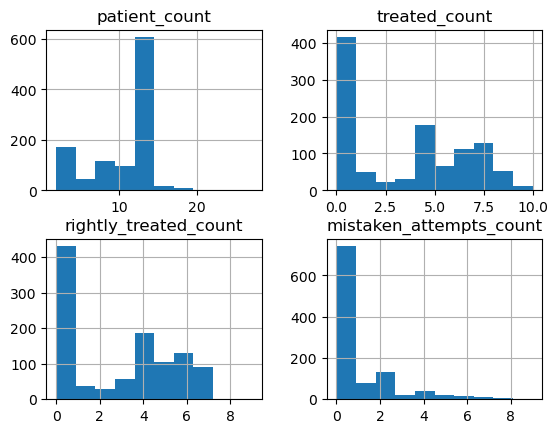

In [11]:

# Visualize histograms of all the distributions
columns_list = ['patient_count', 'treated_count', 'rightly_treated_count', 'mistaken_attempts_count']
rightly_treated_count_df[columns_list].hist();



## Did they do it in the right order?

(Red, Gray, Black), then wavers, then walkers last

In [12]:

# Investigate the presence of black
srs = frvrs_logs_df.applymap(lambda x: 'black' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['voice_capture_message', 'voice_command_command_description', 'tag_selected_type', 'tag_applied_type', 'tag_discarded_type']

In [13]:

# Investigate the presence of wave
srs = frvrs_logs_df.applymap(lambda x: 'wave' in str(x).lower(), na_action='ignore').sum()
columns_list = srs[srs != 0].index.tolist()
columns_list

['action_type', 'patient_demoted_sort', 'voice_capture_message', 'voice_command_message', 'voice_command_command_description', 'patient_record_sort', 's_a_l_t_wave_if_can_sort_command_text', 's_a_l_t_waved_sort_command_text', 'patient_engaged_sort']


#### Edge cases

The worst-case scenario is displayed as the blue vertical bar at the far left of the histogram. The best-case scenario is a component of the right-most vertical bar.

In [17]:

# Display a sample of adjusted R-squared at its maximum, dropping columns with all NaN values and transposing it
max_rsquared_adj = engagement_sort_df.rsquared_adj.max()
mask_series = engagement_sort_df.rsquared_adj.isin([max_rsquared_adj])
df = engagement_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,277,522,785,402
logger_version,1.3,1.0,1.3,1.0
session_uuid,37ed31fb-6f8a-4cc0-b80e-ac4138e42405,741e494b-63ff-4ea2-ad88-657f2276045d,b5a82a5b-e259-4d87-bdb7-94f9cb1ce6ea,5dce5abe-7ded-46e7-8d07-b2e2cd76ef55
scene_index,2,1,1,1
last_threat_engaged,1005491.0,271506.0,279352.0,143073.0
last_walker_engaged,1005491.0,272859.0,283207.0,157464.0
rsquared_adj,1.0,1.0,1.0,1.0
last_still_engaged,530803.0,89570.0,48755.0,58727.0
last_waver_engaged,778433.0,108946.0,124270.0,116633.0
stills_finished_first,True,True,True,True


In [18]:

# Display a sample of adjusted R-squared at its minimum, dropping columns with all NaN values and transposing it
min_rsquared_adj = engagement_sort_df.rsquared_adj.min()
mask_series = engagement_sort_df.rsquared_adj.isin([min_rsquared_adj])
df = engagement_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,65
logger_version,1.0
session_uuid,0b891add-e0c3-463d-948d-7f491f1d10ef
scene_index,4
last_threat_engaged,676501.0
last_walker_engaged,653151.0
rsquared_adj,-0.5
last_still_engaged,676501.0
last_waver_engaged,722393.0
stills_finished_first,False


In [19]:

# In the worse-case scenario, the responder was supposed to engage the waver first, then the two walkers
# Instead, they engaged one of the walkers, then a waver, then the other walker
session_uuid = '274ce308-c366-4829-b9cc-d535b51d16d3'
scene_index = 1
engaged_sort_dict = {'walker': [54614, 102065], 'waver': [88520]}
ideal_sequence = []
for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
ideal_sequence = pd.Series(data=ideal_sequence)
actual_sequence = ideal_sequence.sort_values(ascending=True)
print(f'ideal_sequence = {ideal_sequence.tolist()}\nactual_sequence = {actual_sequence.tolist()}')
X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
X1 = sm.add_constant(X)
try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
except: rsquared_adj = np.nan
print(f'rsquared_adj = {rsquared_adj}')

ideal_sequence = [88520, 54614, 102065]
actual_sequence = [54614, 88520, 102065]
rsquared_adj = -0.9971283921806686


In [20]:

# In the best-case scenario, the responder was supposed to engage the still first, then the waver, then the walkers
# They executed this in the correct sequence
session_uuid = '7de52180-d823-4f9e-9003-aeab8139970b'
scene_index = 1
engaged_sort_dict = {'still': [56434], 'walker': [164294, 195562, 208187, 210397, 211747, 212450, 212649], 'waver': [108854]}
ideal_sequence = []
for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
ideal_sequence = pd.Series(data=ideal_sequence)
actual_sequence = ideal_sequence.sort_values(ascending=True)
print(f'ideal_sequence = {ideal_sequence.tolist()}\nactual_sequence = {actual_sequence.tolist()}')
X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
X1 = sm.add_constant(X)
try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
except: rsquared_adj = np.nan
print(f'rsquared_adj = {rsquared_adj}')

ideal_sequence = [56434, 108854, 164294, 195562, 208187, 210397, 211747, 212450, 212649]
actual_sequence = [56434, 108854, 164294, 195562, 208187, 210397, 211747, 212450, 212649]
rsquared_adj = 1.0



### Stills Finished First

In [21]:

# Verify that the stills were finished first
import numpy as np

f = lambda df: df.last_still_engaged == min(df.last_still_engaged, df.last_walker_engaged, df.last_waver_engaged)
engagement_sort_df['stills_finished_first'] = engagement_sort_df.apply(f, axis='columns')

# Create a mask where any of the last engaged columns are NaN and set the stills finished first column to NaN if true
columns_list = ['last_still_engaged', 'last_walker_engaged', 'last_waver_engaged']
mask_series = engagement_sort_df[columns_list].isnull().any(axis='columns')
engagement_sort_df.loc[mask_series, 'stills_finished_first'] = np.nan

mask_series = (engagement_sort_df.stills_finished_first == False)
df = engagement_sort_df[mask_series]
display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)

,862,731,466,783
logger_version,1.0,1.0,1.0,1.3
session_uuid,cf953248-e6cf-4544-95ce-4843d0f56f10,ab1f8cd1-8d65-45da-b087-89b25ff46c66,693461dd-b8f6-4c60-92b6-bd1db0ffcac8,b541f5c9-93fe-4ef3-9fe7-38493b8aa8a8
scene_index,2,1,1,2
last_threat_engaged,822747.0,748245.0,447319.0,712932.0
last_walker_engaged,770516.0,613587.0,392835.0,681491.0
rsquared_adj,0.516312,0.058678,0.180085,0.446786
last_still_engaged,822747.0,748245.0,447319.0,712932.0
last_waver_engaged,835218.0,735900.0,301317.0,570074.0
stills_finished_first,False,False,False,False


In [25]:

cn = 'voice_capture_message'
mask_series = frvrs_logs_df[cn].isnull()
# sorted([vc for vc in frvrs_logs_df[~mask_series][cn]], key=lambda x: len(x))[-10:]
srs = frvrs_logs_df[~mask_series][cn].value_counts()
mask_series = srs.index.map(lambda x: len(x) > 25)
srs[mask_series].head(10)

are you hurt anywhere else                     16
do you have any other injuries                 13
if you can hear me wave your hand               9
are you hurting anywhere else                   7
anybody that can wave wave                      6
have you heard anywhere else                    5
sir can you tell me your name                   5
if you can hear my voice I want you to wave     4
if you can hear my voice wave                   4
are you injured anywhere else                   4
Name: voice_capture_message, dtype: int64